# Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl ; mpl.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt ; plt.rcParams['font.family'] = 'AppleGothic'
import seaborn as sns

---

In [2]:
# Train Data 불러오기 및 오류 데이터 제거
train = pd.read_csv('train.csv')
train_error = ['C2085', 'C1397', 'C2431', 'C1649', 'C1036', 'C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
train = train[~train['단지코드'].isin(train_error)].reset_index(drop=True)
print(train.shape)

(2869, 15)


In [3]:
# Test Data 불러오기 및 오류 데이터 제거
test = pd.read_csv('test.csv')
test_error = ['C2675', 'C2335', 'C1327']
test = test[~test['단지코드'].isin(test_error)].reset_index(drop=True)
print(test.shape)

(1008, 14)


---

In [4]:
# Train Data의 '상가수' 변수 생성
store = train[train['임대건물구분'] == '상가'].groupby('단지코드', as_index=False).agg({'임대건물구분':'count'}).rename(columns={'임대건물구분':'상가수'})
train = pd.merge(train, store, how='left')
train['상가수'] = train['상가수'].fillna(0)

In [5]:
# Test Data의 '상가수' 변수 생성
store = test[test['임대건물구분'] == '상가'].groupby('단지코드', as_index=False).agg({'임대건물구분':'count'}).rename(columns={'임대건물구분':'상가수'})
test = pd.merge(test, store, how='left')
test['상가수'] = test['상가수'].fillna(0)

In [6]:
# Train Data의 '임대건물구분 == 상가' 데이터 제거, '임대건물구분' 변수 제거
train = train[train['임대건물구분'] != '상가'].reset_index(drop=True)
train.drop(['임대건물구분'], axis=1, inplace=True)
print(train.shape)

(2307, 15)


In [7]:
# Test Data의 '임대건물구분 == 상가' 데이터 제거, '임대건물구분' 변수 제거
test = test[test['임대건물구분'] != '상가'].reset_index(drop=True)
test.drop(['임대건물구분'], axis=1, inplace=True)
print(test.shape)

(831, 14)


---

In [8]:
# Train Data의 '전용면적별세대수합' 변수 생성
noh_by_area = train.groupby('단지코드', as_index=False).agg({'전용면적별세대수':'sum'}).rename(columns={'전용면적별세대수':'전용면적별세대수합'})
train = pd.merge(left=train, right=noh_by_area, how='left', on='단지코드')
print(train.shape)

(2307, 16)


In [9]:
# Test Data의 '전용면적별세대수합' 변수 생성
noh_by_area = test.groupby('단지코드', as_index=False).agg({'전용면적별세대수':'sum'}).rename(columns={'전용면적별세대수':'전용면적별세대수합'})
test = pd.merge(left=test, right=noh_by_area, how='left', on='단지코드')
print(test.shape)

(831, 15)


---

In [10]:
print(set(train['지역'].unique()) - set(test['지역'].unique()))
print(set(train['자격유형'].unique()) - set(test['자격유형'].unique()))
print(set(train['공급유형'].unique()) - set(test['공급유형'].unique()))

{'서울특별시'}
{'B', 'F', 'O'}
{'장기전세', '공공임대(5년)', '공공분양'}


In [11]:
# Test Data에 없는 카테고리 Train Data에서 제거
train = train[train['지역'] != '서울특별시'].reset_index(drop=True)
train = train[~train['자격유형'].isin(['F', 'O', 'B'])].reset_index(drop=True)
train = train[~train['공급유형'].isin(['공공분양', '공공임대(5년)', '장기전세'])].reset_index(drop=True)
print(train.shape)

(2222, 16)


---

In [12]:
# Train Data의 '임대보증금', '임대료'의 '-'를 0으로 변환
train['임대보증금'] = train['임대보증금'].replace('-', 0).astype('float64')
train['임대료'] = train['임대료'].replace('-', 0).astype('float64')

In [13]:
# Test Data의 '임대보증금', '임대료'의 '-'를 0으로 변환
test['임대보증금'] = test['임대보증금'].replace('-', 0).astype('float64')
test['임대료'] = test['임대료'].replace('-', 0).astype('float64')

---

In [14]:
# Train Data의 '도보 10분거리 내 지하철역 수(환승노선 수 반영)' NA 0으로 대체
train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0)

In [15]:
# Test Data의 '도보 10분거리 내 지하철역 수(환승노선 수 반영)' NA 0으로 대체
test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].fillna(0)

---

In [16]:
# Test Data의 '단지코드' NA 특정값으로 대체
test.loc[test['단지코드'] == 'C2411', '자격유형'] = 'A'
test.loc[test['단지코드'] == 'C2253', '자격유형'] = 'D'

---

In [17]:
# Test Data의 '임대보증금', '임대료' NA 특정값으로 대체
test.loc[test['임대보증금'].isnull(), '임대보증금'] = [5787000.0, 5787000.0, 11574000.0]
test.loc[test['임대료'].isnull(), '임대료'] = [79980.0, 79980.0, 159960.0]

---

In [18]:
# Train Data의 '차량미보유세대수' 변수 생성
noh_wo_cars = train[train['공급유형'].isin(['영구임대', '행복주택'])].groupby('단지코드', as_index=False).agg({'전용면적별세대수':'sum'}).rename(columns={'전용면적별세대수':'차량미보유세대수'})
train = pd.merge(train, noh_wo_cars, how='left')
train['차량미보유세대수'] = train['차량미보유세대수'].fillna(0)
train.drop(['공급유형', '자격유형'], axis=1, inplace=True)

In [19]:
# Test Data의 '차량미보유세대수' 변수 생성
noh_wo_cars = test[test['공급유형'].isin(['영구임대', '행복주택'])].groupby('단지코드', as_index=False).agg({'전용면적별세대수':'sum'}).rename(columns={'전용면적별세대수':'차량미보유세대수'})
test = pd.merge(test, noh_wo_cars, how='left')
test['차량미보유세대수'] = test['차량미보유세대수'].fillna(0)
test.drop(['공급유형', '자격유형'], axis=1, inplace=True)

---

In [20]:
# Train Data의 '임대료' 변수 재생성 (전용면적별세대수 가중 평균)
train['임대료'] = round(train['임대료'] * train['전용면적별세대수'] / train['전용면적별세대수합'])
rental_fee = train.groupby('단지코드', as_index=False).agg({'임대료':'sum'})
train = pd.merge(train, rental_fee, how='left', on='단지코드').drop(['임대료_x'], axis=1).rename(columns={'임대료_y':'임대료'})

In [21]:
# Test Data의 '임대료' 변수 재생성 (전용면적별세대수 가중 평균)
test['임대료'] = round(test['임대료'] * test['전용면적별세대수'] / test['전용면적별세대수합'])
rental_fee = test.groupby('단지코드', as_index=False).agg({'임대료':'sum'})
test = pd.merge(test, rental_fee, how='left', on='단지코드').drop(['임대료_x'], axis=1).rename(columns={'임대료_y':'임대료'})

In [22]:
# Train Data의 '임대보증금' 변수 재생성 (전용면적별세대수 가중 평균)
train['임대보증금'] = round(train['임대보증금'] * train['전용면적별세대수'] / train['전용면적별세대수합'])
rental_fee = train.groupby('단지코드', as_index=False).agg({'임대보증금':'sum'})
train = pd.merge(train, rental_fee, how='left', on='단지코드').drop(['임대보증금_x'], axis=1).rename(columns={'임대보증금_y':'임대보증금'})

In [23]:
# Test Data의 '임대보증금' 변수 재생성 (전용면적별세대수 가중 평균)
test['임대보증금'] = round(test['임대보증금'] * test['전용면적별세대수'] / test['전용면적별세대수합'])
rental_fee = test.groupby('단지코드', as_index=False).agg({'임대보증금':'sum'})
test = pd.merge(test, rental_fee, how='left', on='단지코드').drop(['임대보증금_x'], axis=1).rename(columns={'임대보증금_y':'임대보증금'})

---

In [24]:
# Train Data의 '전용면적' 변수 재생성 (전용면적별세대수 가중 평균)
train['전용면적'] = round(train['전용면적'] * train['전용면적별세대수'] / train['전용면적별세대수합'])
rental_fee = train.groupby('단지코드', as_index=False).agg({'전용면적':'sum'})
train = pd.merge(train, rental_fee, how='left', on='단지코드').drop(['전용면적_x'], axis=1).rename(columns={'전용면적_y':'전용면적'})

In [25]:
# Test Data의 '전용면적' 변수 재생성 (전용면적별세대수 가중 평균)
test['전용면적'] = round(test['전용면적'] * test['전용면적별세대수'] / test['전용면적별세대수합'])
rental_fee = test.groupby('단지코드', as_index=False).agg({'전용면적':'sum'})
test = pd.merge(test, rental_fee, how='left', on='단지코드').drop(['전용면적_x'], axis=1).rename(columns={'전용면적_y':'전용면적'})

---

In [26]:
# Train Data의 '아파트수' 변수 생성
num_of_apt = pd.DataFrame(train['단지코드'].value_counts()).reset_index().rename(columns={'index':'단지코드', '단지코드':'아파트수'})
train = pd.merge(train, num_of_apt, how='left', on='단지코드')
print(train.shape)

(2222, 16)


In [27]:
# Test Data의 '아파트수' 변수 생성
num_of_apt = pd.DataFrame(test['단지코드'].value_counts()).reset_index().rename(columns={'index':'단지코드', '단지코드':'아파트수'})
test = pd.merge(test, num_of_apt, how='left', on='단지코드')
print(test.shape)

(831, 15)


---

In [28]:
# Train Data의 '차량보유인구비율' 변수 생성
age_gender_info = pd.read_csv('age_gender_info.csv')
cars = pd.DataFrame(age_gender_info.iloc[:, [7, 8, 9, 10, 12, 14]].sum(axis=1), columns=['차량보유인구비율'])
cars['지역'] = age_gender_info['지역']
train = pd.merge(train, cars, how='left', on='지역')
print(train.shape)

(2222, 17)


In [29]:
# Test Data의 '차량보유인구비율' 변수 생성
test = pd.merge(test, cars, how='left', on='지역')
print(test.shape)

(831, 16)


---

In [30]:
tmp = train.drop(['전용면적별세대수'], axis=1).drop_duplicates().reset_index(drop=True)

In [31]:
tmp['차량미보유세대비율'] = tmp['차량미보유세대수'] / tmp['총세대수']

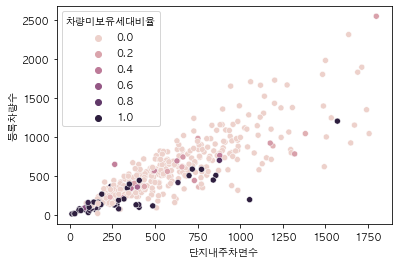

In [32]:
fig, ax = plt.subplots()
sns.scatterplot(x='단지내주차면수', y='등록차량수', data=tmp, hue='차량미보유세대비율')
plt.show()

In [33]:
X_train = tmp[['단지내주차면수', '차량미보유세대비율', '전용면적', '차량보유인구비율', '공가수']]
y_train = tmp['등록차량수']

In [34]:
from sklearn.preprocessing import PolynomialFeatures

In [35]:
poly = PolynomialFeatures(2, interaction_only=True)

In [36]:
X_train = poly.fit_transform(X_train)

In [37]:
from sklearn.preprocessing import StandardScaler

In [38]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [39]:
X_train = scaler.transform(X_train)

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [41]:
lr = LinearRegression()

In [42]:
score = cross_val_score(lr, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

In [43]:
print(f'평균: {-score.mean()} | 표준편차: {score.std()}')

평균: 118.88391097533801 | 표준편차: 29.188948212581263


In [44]:
from sklearn.linear_model import Ridge

In [45]:
best_alpha = []
for i in range(30):
    rg = Ridge(alpha=i)
    score = cross_val_score(rg, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
    best_alpha.append(-score.mean())
print(f'Best alpha is {np.argmin(best_alpha)}.')

Best alpha is 11.


In [46]:
rg = Ridge(alpha=11)

In [47]:
score = cross_val_score(rg, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')

In [48]:
print(f'평균: {-score.mean()} | 표준편차: {score.std()}')

평균: 118.21936658088836 | 표준편차: 31.62583487452536


In [49]:
rg.fit(X_train, y_train)

Ridge(alpha=11)

---

In [50]:
tmp_test = test.drop(['전용면적별세대수'], axis=1).drop_duplicates().reset_index(drop=True)

In [51]:
tmp_test['차량미보유세대비율'] = tmp_test['차량미보유세대수'] / tmp_test['총세대수']

In [52]:
X_test = tmp_test[['단지내주차면수', '차량미보유세대비율', '전용면적', '차량보유인구비율', '공가수']]

In [53]:
poly = PolynomialFeatures(2, interaction_only=True)

In [54]:
X_test = poly.fit_transform(X_test)

In [55]:
X_test = scaler.transform(X_test)

In [56]:
tmp_test['등록차량수'] = rg.predict(X_test)

In [57]:
submission = tmp_test[['단지코드', '등록차량수']].rename(columns={'단지코드':'code', '등록차량수':'num'})

In [58]:
error = pd.DataFrame(np.array([['C2675', 0], ['C2335', 0], ['C1327', 0]]), columns=['code', 'num'])

In [59]:
submission = pd.concat([submission, error]).reset_index(drop=True)

In [60]:
submission.to_csv('submission.csv', index=False)